# Imports

In [25]:
%load_ext autoreload
%autoreload 2

%load_ext nb_black

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
The nb_black extension is already loaded. To reload it, use:
  %reload_ext nb_black


<IPython.core.display.Javascript object>

In [26]:
#export
from exp.nb_06 import *

<IPython.core.display.Javascript object>

[Jump_to lesson 10 video](https://course.fast.ai/videos/?lesson=10&t=5899)

# ConvNet

Let's get the data and training interface from where we left in the last notebook.

In [27]:
x_train, y_train, x_valid, y_valid = get_data()

x_train, x_valid = normalize_to(x_train, x_valid)
train_ds, valid_ds = Dataset(x_train, y_train), Dataset(x_valid, y_valid)

nh, bs = 50, 512
c = y_train.max().item() + 1
loss_func = F.cross_entropy

data = DataBunch(*get_dls(train_ds, valid_ds, bs), c)

<IPython.core.display.Javascript object>

In [28]:
mnist_view = view_tfm(1, 28, 28)
cbfs = [
    Recorder,
    partial(AvgStatsCallback, accuracy),
    partial(BatchTransformXCallback, mnist_view)
]

<IPython.core.display.Javascript object>

In [29]:
nfs = [8, 16, 32, 64, 64]

<IPython.core.display.Javascript object>

In [30]:
learner = get_learn_run(nfs, data, 0.4, conv_layer, cbs=cbfs)

<IPython.core.display.Javascript object>

In [31]:
%time learner.fit(3)

train: [0.706386953125, tensor(0.7708)]
valid: [0.2305280517578125, tensor(0.9210)]
train: [0.144779150390625, tensor(0.9554)]
valid: [0.10903265380859375, tensor(0.9684)]
train: [0.091878505859375, tensor(0.9714)]
valid: [0.08293606567382812, tensor(0.9753)]
CPU times: user 14.7 s, sys: 2.47 s, total: 17.1 s
Wall time: 16.9 s


<IPython.core.display.Javascript object>

# Batchnorm

## Custom

Let's start by building our own `BatchNorm` layer from scratch. In the case of computer vision, the average and std are by channel. Therefore, it is as if we concatenate all images with their heights and width by channel. Therefore, the output would be channels x (batches * height * width).

`self.register_buffer`:

`self.register_buffer('vars',  torch.ones(1,nf,1,1))` is almost the same as `self.vars = torch.ones(1,nf,1,1))` but has the advantage that if we move everything to GPU, they will be moved to GPU too; otherwise, the won't and we will get an error when we try to do some calculations because you can't do calculations on stuff that are on CPU and GPU. It also allows us to save them when we save the model to disk because we need them at inference time.

In [32]:
class BatchNorm(nn.Module):
    __constants__ = ['eps', 'mom']

    def __init__(self, nf, mom=.1, eps=1e-5):
        super().__init__()
        # NB: pytorch bn mom is opposite of what you'd expect
        # This means the beta in exponential weighted average is
        # actually 1 - mom. Therefore, beta is 0.9 here.
        self.eps = eps
        self.mom = mom
        self.gamma = nn.Parameter(torch.ones(nf, 1, 1))
        self.beta = nn.Parameter(torch.zeros(nf, 1, 1))
        self.register_buffer('means', torch.ones(1, nf, 1, 1))
        self.register_buffer('vars', torch.ones(1, nf, 1, 1))

    def update_stats(self, x):
        # Average across batches, height and width --> average across channels.
        mean = x.mean((0, 2, 3), keepdim=True)
        var = x.var((0, 2, 3), keepdim=True)

        # means = (1 - mom) x means + mom x m; exponentially weighted average
        self.means.lerp_(mean, self.mom)
        self.vars.lerp_(var, self.mom)
        return mean, var

    def forward(self, x):
        if self.training:
            mean, var = self.update_stats(x)
        else:
            mean, var = self.means, self.vars
        x = (x - mean) / (var + self.eps).sqrt()
        return self.gamma * x + self.beta

<IPython.core.display.Javascript object>

In [33]:
def conv_layer(ni, nf, ks=3, stride=2, bn=True, **kwargs):
    # No bias needed if using bn
    layers = [
        nn.Conv2d(ni, nf, ks, padding=ks // 2, stride=stride, bias=not bn),
        GeneralRelu(**kwargs)
    ]
    if bn: 
        layers.append(BatchNorm(nf))
    return nn.Sequential(*layers)

<IPython.core.display.Javascript object>

In [34]:
#export
def init_cnn_(m, f):
    if isinstance(m, nn.Conv2d):
        f(m.weight, a=0.1)
        if getattr(m, 'bias', None) is not None:
            m.bias.data.zero_()
    for l in m.children():
        init_cnn_(l, f)


def init_cnn(m, uniform=False):
    f = init.kaiming_uniform_ if uniform else init.kaiming_normal_
    init_cnn_(m, f)


def get_learn_run(nfs,
                  data,
                  lr,
                  layer,
                  cbs=None,
                  opt_func=None,
                  uniform=False,
                  **kwargs):
    model = get_cnn_model(data, nfs, layer, **kwargs)
    init_cnn(model, uniform=uniform)
    return get_learner(model, data, lr=lr, cbs=cbs, opt_func=opt_func)

<IPython.core.display.Javascript object>

We can then use it in training and see how it helps keep the activations means to 0 and the std to 1.

In [35]:
learner = get_learn_run(nfs, data, 0.9, conv_layer, cbs=cbfs)
learner.model

Sequential(
  (0): Sequential(
    (0): Conv2d(1, 8, kernel_size=(5, 5), stride=(2, 2), padding=(2, 2), bias=False)
    (1): GeneralRelu()
    (2): BatchNorm()
  )
  (1): Sequential(
    (0): Conv2d(8, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
    (1): GeneralRelu()
    (2): BatchNorm()
  )
  (2): Sequential(
    (0): Conv2d(16, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
    (1): GeneralRelu()
    (2): BatchNorm()
  )
  (3): Sequential(
    (0): Conv2d(32, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
    (1): GeneralRelu()
    (2): BatchNorm()
  )
  (4): Sequential(
    (0): Conv2d(64, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
    (1): GeneralRelu()
    (2): BatchNorm()
  )
  (5): AdaptiveAvgPool2d(output_size=1)
  (6): Lambda()
  (7): Linear(in_features=64, out_features=10, bias=True)
)

<IPython.core.display.Javascript object>

train: [0.22674857421875, tensor(0.9306)]
valid: [0.09012371826171875, tensor(0.9752)]


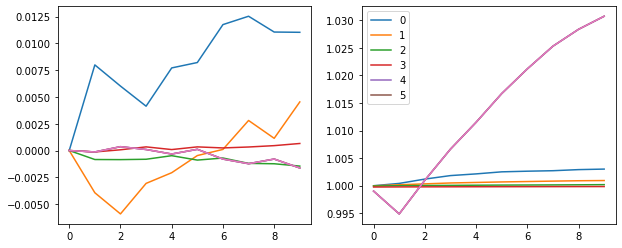

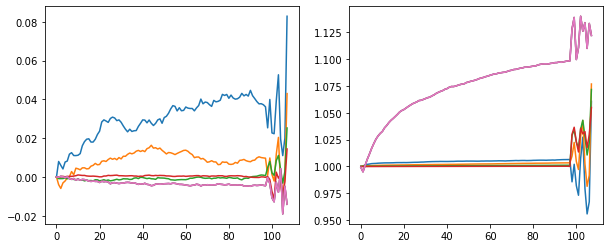

<IPython.core.display.Javascript object>

In [36]:
with Hooks(learner.model, compute_stats, True) as hooks:
    learner.fit(1)
    fig, (ax0, ax1) = plt.subplots(1, 2, figsize=(10, 4))
    for h in hooks[:-1]:
        ms, ss = h.stats
        ax0.plot(ms[:10])
        ax1.plot(ss[:10])
        h.remove()
    plt.legend(range(6))

    fig, (ax0, ax1) = plt.subplots(1, 2, figsize=(10, 4))
    for h in hooks[:-1]:
        ms, ss = h.stats
        ax0.plot(ms)
        ax1.plot(ss)

In [37]:
learner = get_learn_run(nfs, data, 1.0, conv_layer, cbs=cbfs)

<IPython.core.display.Javascript object>

In [38]:
%time learner.fit(3)

train: [0.22072515625, tensor(0.9302)]
valid: [0.08125630493164063, tensor(0.9758)]
train: [0.06308880859375, tensor(0.9802)]
valid: [0.06980171508789063, tensor(0.9779)]
train: [0.0418496337890625, tensor(0.9870)]
valid: [0.062419696044921875, tensor(0.9823)]
CPU times: user 31.7 s, sys: 6.73 s, total: 38.5 s
Wall time: 30.1 s


<IPython.core.display.Javascript object>

## Builtin batchnorm

In [41]:
#export
def conv_layer(ni, nf, ks=3, stride=2, bn=True, **kwargs):
    layers = [
        nn.Conv2d(ni, nf, ks, padding=ks // 2, stride=stride, bias=not bn),
        GeneralRelu(**kwargs)
    ]
    if bn: layers.append(nn.BatchNorm2d(nf, eps=1e-5, momentum=0.1))
    return nn.Sequential(*layers)

<IPython.core.display.Javascript object>

In [43]:
learner = get_learn_run(nfs, data, 1., conv_layer, cbs=cbfs)

<IPython.core.display.Javascript object>

In [46]:
%time learner.fit(3)

train: [0.21926626953125, tensor(0.9319)]
valid: [0.16897113037109374, tensor(0.9461)]
train: [0.070147958984375, tensor(0.9785)]
valid: [0.06425867919921875, tensor(0.9803)]
train: [0.0414489892578125, tensor(0.9874)]
valid: [0.059473565673828124, tensor(0.9821)]
CPU times: user 21.1 s, sys: 3.17 s, total: 24.3 s
Wall time: 21.2 s


<IPython.core.display.Javascript object>

### With scheduler

Now let's add the usual warm-up/annealing.

In [47]:
sched = combine_scheds([0.3, 0.7], [lin_sched(0.6, 2.), lin_sched(2., 0.1)])

<IPython.core.display.Javascript object>

In [50]:
learner = get_learn_run(nfs,
                           data,
                           0.9,
                           conv_layer,
                           cbs=cbfs + [partial(ParamScheduler, 'lr', sched)])

<IPython.core.display.Javascript object>

In [51]:
learner.fit(3)

train: [0.25751087890625, tensor(0.9225)]
valid: [0.1018584228515625, tensor(0.9675)]
train: [0.0627016748046875, tensor(0.9799)]
valid: [0.05202744750976562, tensor(0.9830)]
train: [0.03042097412109375, tensor(0.9910)]
valid: [0.04336961364746094, tensor(0.9871)]


<IPython.core.display.Javascript object>

## More norms

### Layer norm

From [the paper](https://arxiv.org/abs/1607.06450): "*batch normalization cannot be applied to online learning tasks or to extremely large distributed models where the minibatches have to be small*".

The main challenges to **BatchNorm** are:
- How do we handle very small batches because we would have infinite variance or unstable training.
- How do we handle RNNs.

General equation for a norm layer with learnable affine:

$$y = \frac{x - \mathrm{E}[x]}{ \sqrt{\mathrm{Var}[x] + \epsilon}} * \gamma + \beta$$

The difference with BatchNorm is
1. we don't keep a moving average
2. we don't average over the batches dimension but over the hidden dimension, so it's independent of the batch size

In [52]:
class LayerNorm(nn.Module):
    __constants__ = ['eps']

    def __init__(self, eps=1e-5):
        super().__init__()
        self.eps = eps
        self.gamma = nn.Parameter(tensor(1.))
        self.beta = nn.Parameter(tensor(0.))

    def forward(self, x):
        mean = x.mean((1, 2, 3), keepdim=True)
        var = x.var((1, 2, 3), keepdim=True)
        x = (x - mean) / ((var + self.eps).sqrt())
        return x * self.gamma + self.beta

<IPython.core.display.Javascript object>

In [53]:
def conv_ln(ni, nf, ks=3, stride=2, bn=True, **kwargs):
    layers = [
        nn.Conv2d(ni, nf, ks, padding=ks // 2, stride=stride, bias=True),
        GeneralRelu(**kwargs)
    ]
    if bn: layers.append(LayerNorm())
    return nn.Sequential(*layers)

<IPython.core.display.Javascript object>

In [55]:
learner = get_learn_run(nfs, data, 0.8, conv_ln, cbs=cbfs)

<IPython.core.display.Javascript object>

In [56]:
%time learner.fit(3)

train: [nan, tensor(0.1411)]
valid: [nan, tensor(0.0991)]
train: [nan, tensor(0.0986)]
valid: [nan, tensor(0.0991)]
train: [nan, tensor(0.0986)]
valid: [nan, tensor(0.0991)]
CPU times: user 30.1 s, sys: 7.2 s, total: 37.3 s
Wall time: 30.2 s


<IPython.core.display.Javascript object>

*Thought experiment*: can this distinguish foggy days from sunny days (assuming you're using it before the first conv)?

It would be hard to distinguish between them because it forces the means and variances to be the same after normalizing. It throws away the difference in activations and if at inference time there is a difference in distribution that we care about, it would throw that away as well.

### Instance norm

From [the paper](https://arxiv.org/abs/1607.08022): 

The key difference between **contrast** and batch normalization is that the latter applies the normalization to a  whole batch of images instead for single ones:

\begin{equation}\label{eq:bnorm}
    y_{tijk} =  \frac{x_{tijk} - \mu_{i}}{\sqrt{\sigma_i^2 + \epsilon}},
    \quad
    \mu_i = \frac{1}{HWT}\sum_{t=1}^T\sum_{l=1}^W \sum_{m=1}^H x_{tilm},
    \quad
    \sigma_i^2 = \frac{1}{HWT}\sum_{t=1}^T\sum_{l=1}^W \sum_{m=1}^H (x_{tilm} - mu_i)^2.
\end{equation}

In order to combine the effects of instance-specific normalization and batch normalization, we propose to replace the latter by the *instance normalization* (also known as *contrast normalization*) layer:

\begin{equation}\label{eq:inorm}
    y_{tijk} =  \frac{x_{tijk} - \mu_{ti}}{\sqrt{\sigma_{ti}^2 + \epsilon}},
    \quad
    \mu_{ti} = \frac{1}{HW}\sum_{l=1}^W \sum_{m=1}^H x_{tilm},
    \quad
    \sigma_{ti}^2 = \frac{1}{HW}\sum_{l=1}^W \sum_{m=1}^H (x_{tilm} - mu_{ti})^2.
\end{equation}

In [57]:
class InstanceNorm(nn.Module):
    __constants__ = ['eps']

    def __init__(self, nf, eps=1e-0):
        super().__init__()
        self.eps = eps
        self.gamma = nn.Parameter(torch.ones(nf, 1, 1))
        self.beta = nn.Parameter(torch.zeros(nf, 1, 1))

    def forward(self, x):
        mean = x.mean((2, 3), keepdim=True)
        var = x.var((2, 3), keepdim=True)
        res = (x - mean) / ((var + self.eps).sqrt())
        return res * self.gamma + self.beta

<IPython.core.display.Javascript object>

In [58]:
def conv_in(ni, nf, ks=3, stride=2, bn=True, **kwargs):
    layers = [
        nn.Conv2d(ni, nf, ks, padding=ks // 2, stride=stride, bias=True),
        GeneralRelu(**kwargs)
    ]
    if bn: layers.append(InstanceNorm(nf))
    return nn.Sequential(*layers)

<IPython.core.display.Javascript object>

In [59]:
learner = get_learn_run(nfs, data, 0.1, conv_in, cbs=cbfs)

<IPython.core.display.Javascript object>

In [60]:
%time learner.fit(3)

train: [nan, tensor(0.0986)]
valid: [nan, tensor(0.0991)]
train: [nan, tensor(0.0986)]
valid: [nan, tensor(0.0991)]
train: [nan, tensor(0.0986)]
valid: [nan, tensor(0.0991)]
CPU times: user 40.8 s, sys: 7.78 s, total: 48.6 s
Wall time: 36.3 s


<IPython.core.display.Javascript object>

*Question*: why can't this classify anything?

Because it throws the difference in the means and variances of each image and each channel. It is useful for style transfer.

### Group norm

Lost in all those norms? The authors from the [group norm paper](https://arxiv.org/pdf/1803.08494.pdf) have you covered:

<img src="images/norms.png">

*From the PyTorch docs:*

`GroupNorm(num_groups, num_channels, eps=1e-5, affine=True)`

The input channels are separated into `num_groups` groups, each containing
``num_channels / num_groups`` channels. The mean and standard-deviation are calculated
separately over the each group. $\gamma$ and $\beta$ are learnable
per-channel affine transform parameter vectorss of size `num_channels` if
`affine` is ``True``.

This layer uses statistics computed from input data in both training and
evaluation modes.

Args:
-    num_groups (int): number of groups to separate the channels into
-    num_channels (int): number of channels expected in input
-    eps: a value added to the denominator for numerical stability. Default: 1e-5
-    affine: a boolean value that when set to ``True``, this module
        has learnable per-channel affine parameters initialized to ones (for weights)
        and zeros (for biases). Default: ``True``.

Shape:
- Input: `(N, num_channels, *)`
- Output: `(N, num_channels, *)` (same shape as input)

Examples::

    >>> input = torch.randn(20, 6, 10, 10)
    >>> # Separate 6 channels into 3 groups
    >>> m = nn.GroupNorm(3, 6)
    >>> # Separate 6 channels into 6 groups (equivalent with InstanceNorm)
    >>> m = nn.GroupNorm(6, 6)
    >>> # Put all 6 channels into a single group (equivalent with LayerNorm)
    >>> m = nn.GroupNorm(1, 6)
    >>> # Activating the module
    >>> output = m(input)

## Fix small batch sizes

### What's the problem?

When we compute the statistics (mean and std) for a BatchNorm Layer on a small batch, it is possible that we get a standard deviation very close to 0. because there aren't many samples (the variance of one thing is 0. since it's equal to its mean).

In [29]:
data = DataBunch(*get_dls(train_ds, valid_ds, 2), c)

<IPython.core.display.Javascript object>

In [30]:
def conv_layer(ni, nf, ks=3, stride=2, bn=True, **kwargs):
    layers = [
        nn.Conv2d(ni, nf, ks, padding=ks // 2, stride=stride, bias=not bn),
        GeneralRelu(**kwargs)
    ]
    if bn: layers.append(nn.BatchNorm2d(nf, eps=1e-5, momentum=0.1))
    return nn.Sequential(*layers)

<IPython.core.display.Javascript object>

In [31]:
learn,run = get_learn_run(nfs, data, 0.4, conv_layer, cbs=cbfs)

<IPython.core.display.Javascript object>

In [32]:
%time run.fit(1, learn)

train: [2.35215484375, tensor(0.1710)]
valid: [1548761117.4912, tensor(0.1431)]
CPU times: user 1min 51s, sys: 361 ms, total: 1min 51s
Wall time: 1min 51s


<IPython.core.display.Javascript object>

### Running Batch Norm

To solve this problem we introduce a Running BatchNorm that uses smoother running mean and variance for the mean and std.

In [33]:
class RunningBatchNorm(nn.Module):
    def __init__(self, nf, mom=0.1, eps=1e-5):
        super().__init__()
        self.mom, self.eps = mom, eps
        self.mults = nn.Parameter(torch.ones(nf, 1, 1))
        self.adds = nn.Parameter(torch.zeros(nf, 1, 1))
        self.register_buffer('sums', torch.zeros(1, nf, 1, 1))
        self.register_buffer('sqrs', torch.zeros(1, nf, 1, 1))
        self.register_buffer('batch', tensor(0.))
        self.register_buffer('count', tensor(0.))
        self.register_buffer('factor', tensor(0.))
        self.register_buffer('offset', tensor(0.))

    def update_stats(self, x):
        bs, nc, *_ = x.shape
        self.sums.detach_()
        self.sqrs.detach_()
        dims = (0, 2, 3)
        s = x.sum(dims, keepdim=True)
        ss = (x * x).sum(dims, keepdim=True)
        c = self.count.new_tensor(x.numel() / nc)
        mom1 = 1 - (1 - self.mom) / math.sqrt(bs-1)
        self.sums.lerp_(s, mom1)
        self.sqrs.lerp_(ss, mom1)
        self.count.lerp_(c, mom1)
        self.batch += bs
        means = self.sums / self.count
        var = (self.sqrs / self.count).sub_(means * means)

        if bool(self.batch < 20):
            var.clamp_min_(0.01)

        self.factor = self.mults / (var + self.eps).sqrt()
        self.offset = self.adds - means * self.factor

    def forward(self, x):
        if self.training:
            self.update_stats(x)
        return x * self.factor + self.offset

<IPython.core.display.Javascript object>

In [34]:
def conv_rbn(ni, nf, ks=3, stride=2, bn=True, **kwargs):
    layers = [nn.Conv2d(ni, nf, ks, padding=ks//2, stride=stride, bias=not bn),
              GeneralRelu(**kwargs)]
    if bn: layers.append(RunningBatchNorm(nf))
    return nn.Sequential(*layers)

<IPython.core.display.Javascript object>

In [35]:
learn,run = get_learn_run(nfs, data, 0.4, conv_rbn, cbs=cbfs)

<IPython.core.display.Javascript object>

In [36]:
learn.model

Sequential(
  (0): Sequential(
    (0): Conv2d(1, 8, kernel_size=(5, 5), stride=(2, 2), padding=(2, 2), bias=False)
    (1): GeneralRelu()
    (2): RunningBatchNorm()
  )
  (1): Sequential(
    (0): Conv2d(8, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
    (1): GeneralRelu()
    (2): RunningBatchNorm()
  )
  (2): Sequential(
    (0): Conv2d(16, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
    (1): GeneralRelu()
    (2): RunningBatchNorm()
  )
  (3): Sequential(
    (0): Conv2d(32, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
    (1): GeneralRelu()
    (2): RunningBatchNorm()
  )
  (4): Sequential(
    (0): Conv2d(64, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
    (1): GeneralRelu()
    (2): RunningBatchNorm()
  )
  (5): AdaptiveAvgPool2d(output_size=1)
  (6): Lambda()
  (7): Linear(in_features=64, out_features=10, bias=True)
)

<IPython.core.display.Javascript object>

In [37]:
%time run.fit(1, learn)

train: [0.4170171875, tensor(0.8936)]
valid: [0.3150417236328125, tensor(0.9235)]
CPU times: user 1min 51s, sys: 418 ms, total: 1min 52s
Wall time: 1min 52s


<IPython.core.display.Javascript object>

This solves the small batch size issue!

### What can we do in a single epoch?

Now let's see with a decent batch size what result we can get.

In [38]:
data = DataBunch(*get_dls(train_ds, valid_ds, 512), c)

<IPython.core.display.Javascript object>

In [39]:
learn, run = get_learn_run(nfs, data, 1., conv_layer, cbs=cbfs)

<IPython.core.display.Javascript object>

In [40]:
%time run.fit(3, learn)

train: [0.22383076171875, tensor(0.9292)]
valid: [0.09052369384765625, tensor(0.9712)]
train: [0.0656801171875, tensor(0.9794)]
valid: [0.06957890014648438, tensor(0.9794)]
train: [0.044756376953125, tensor(0.9858)]
valid: [0.07446788940429687, tensor(0.9781)]
CPU times: user 47.1 s, sys: 2.92 s, total: 50.1 s
Wall time: 25.2 s


<IPython.core.display.Javascript object>

In [41]:
# learn,run = get_learn_run(nfs, data, 0.9, conv_rbn, cbs=cbfs
#                           +[partial(ParamScheduler,'lr', sched_lin(1., 0.2))])

<IPython.core.display.Javascript object>

In [42]:
%time run.fit(3, learn)

train: [0.032991181640625, tensor(0.9894)]
valid: [0.0602272705078125, tensor(0.9817)]
train: [0.02374192626953125, tensor(0.9923)]
valid: [0.06647666015625, tensor(0.9819)]
train: [0.0173309326171875, tensor(0.9948)]
valid: [0.08294573974609375, tensor(0.9761)]
CPU times: user 46.8 s, sys: 2.88 s, total: 49.7 s
Wall time: 25 s


<IPython.core.display.Javascript object>

## Export

In [61]:
!python ../src/notebook2script.py 07_BatchNormalization-Imad.ipynb

Converted 07_BatchNormalization-Imad.ipynb to exp/nb_07.py


<IPython.core.display.Javascript object>